
# Chapter 11



# Lab: Survival Analysis
 In this lab, we perform survival analyses on three separate data
sets. In  Section 11.8.1 we analyze the  `BrainCancer` 
data  that was first described in Section 11.3. In Section 11.8.2, we examine the  `Publication` 
data  from Section 11.5.4. Finally,  Section 11.8.3  explores
a simulated call-center data set.

We begin by importing some of our libraries at this top
level. This makes the code more readable, as scanning the first few
lines of the notebook tell us what libraries are used in this
notebook.

In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

import warnings
warnings.filterwarnings('ignore')


We  also collect the new imports
needed for this lab.

In [2]:
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time


## Brain Cancer Data

We begin with the `BrainCancer` data set, contained in the `ISLP` package.

In [3]:
BrainCancer = load_data('BrainCancer')
BrainCancer.columns


Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

The rows index the 88 patients, while the 8 columns contain the predictors and outcome variables.
We first briefly examine the data.

In [4]:
BrainCancer['sex'].value_counts()


Female    45
Male      43
Name: sex, dtype: int64

In [5]:
BrainCancer['diagnosis'].value_counts()


Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [6]:
BrainCancer['status'].value_counts()


0    53
1    35
Name: status, dtype: int64

Before beginning an analysis, it is important to know how the
`status` variable has been coded.  Most software
uses the convention that a `status` of 1 indicates an
uncensored observation (often death), and a `status` of 0 indicates a censored
observation. But some scientists might use the opposite coding. For
the  `BrainCancer`  data set 35 patients died before the end of
the study, so we are using the conventional coding.

To begin the analysis, we re-create  the Kaplan-Meier survival curve shown in Figure 11.2. The main
package we will use for survival analysis
is `lifelines`.
The variable  `time`  corresponds to $y_i$, the time to the $i$th event (either censoring or
death). The first argument to `km.fit` is the event time, and the
second argument is the censoring variable, with a 1 indicating an observed
failure time. The `plot()` method produces a survival curve with pointwise confidence
intervals. By default, these are  90% confidence intervals, but this can be changed
by setting the `alpha` argument to one minus the desired
confidence level.

<Axes: xlabel='timeline'>

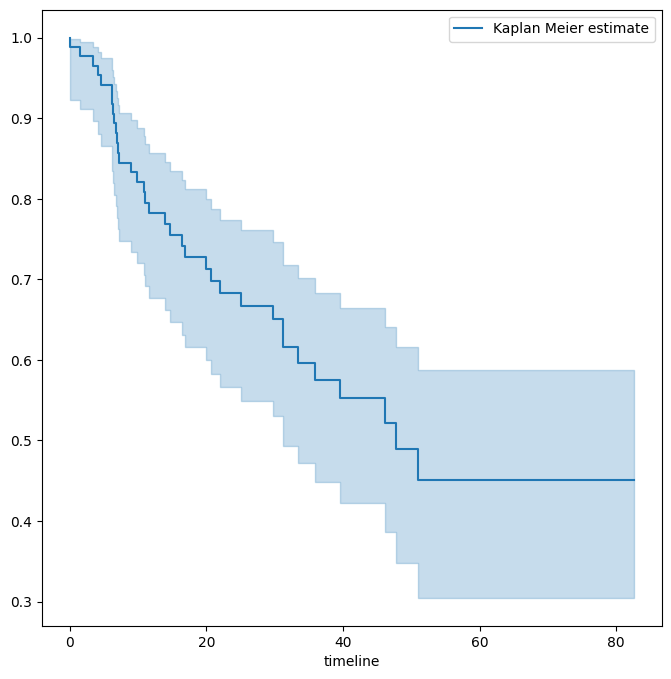

In [7]:
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax)


Next we create Kaplan-Meier survival curves that are stratified by
`sex`, in order to reproduce  Figure 11.3.
We  do this using the `groupby()` method of  a  dataframe.
This  method returns a generator that can
be  iterated over in the `for` loop. In this case,
the  items  in the `for` loop are  2-tuples  representing
the groups: the first entry is the  value
of the grouping column  `sex` while the  second  value
is the dataframe consisting of all  rows in the
dataframe matching that value of `sex`.
We will want to use this data below
in the log-rank test,  hence we store this
information in the dictionary `by_sex`. Finally,
we have also used the notion of
 *string interpolation* to automatically
label the  different lines in the  plot. String
interpolation is a powerful technique to format strings ---
`Python` has many ways to facilitate such operations.

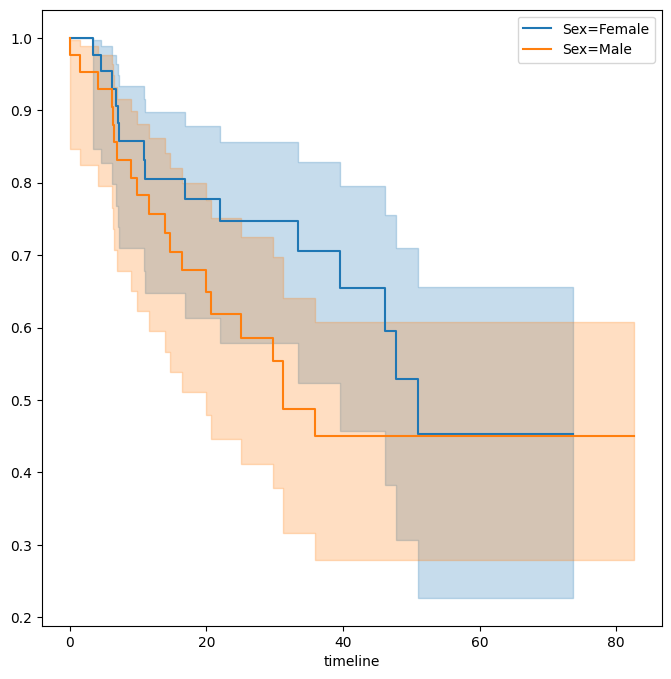

In [8]:
fig, ax = subplots(figsize=(8,8))
by_sex = {}
for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label='Sex=%s' % sex, ax=ax)


As discussed in Section 11.4, we can perform a
log-rank test to compare the survival of males to females. We use
the `logrank_test()` function from the `lifelines.statistics` module.
The first two arguments are the event times, with the second
denoting the corresponding (optional) censoring indicators.

In [9]:
logrank_test(by_sex['Male']['time'],
             by_sex['Female']['time'],
             by_sex['Male']['status'],
             by_sex['Female']['status'])


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

The resulting $p$-value is $0.23$, indicating no evidence of a
difference in survival between the two sexes.

Next, we  use the `CoxPHFitter()`  estimator
from `lifelines` to fit Cox proportional hazards models.
To begin, we consider a model that uses  `sex`  as the only predictor.

In [10]:
coxph = CoxPHFitter # shorthand
sex_df = BrainCancer[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'],
              intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df,
                      'time',
                      'status')
cox_fit.summary[['coef', 'se(coef)', 'p']]


,coef,se(coef),p
covariate,,,
sex[Male],0.407668,0.342004,0.233262


The first argument to `fit` should be a data frame containing
at least the event time (the second argument `time` in this case),
as well as an optional censoring variable (the argument `status` in this case).
Note also that the Cox model does not include an intercept, which is why
we used the `intercept=False` argument to `ModelSpec` above.
The `summary()` method delivers many columns; we chose to abbreviate its output here.
It is possible to obtain the likelihood ratio test comparing this model to the one
with no features as follows:

In [11]:
cox_fit.log_likelihood_ratio_test()


<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

Regardless of which test we use, we see that there is no clear
evidence for a difference in survival between males and females.  As
we learned in this chapter, the score test from the Cox model is
exactly equal to the log rank test statistic!

Now we fit a  model that makes use of additional predictors. We first note
that one of our `diagnosis` values is missing, hence
we drop that observation before continuing.

In [12]:
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df,
                      'time',
                      'status')
fit_all.summary[['coef', 'se(coef)', 'p']]


,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


 The `diagnosis` variable has been coded so that the baseline
corresponds to HG glioma. The results indicate that the risk associated with HG glioma
is more than eight times (i.e. $e^{2.15}=8.62$) the risk associated
with meningioma. In other words, after adjusting for the other
predictors, patients with HG glioma have much worse survival compared
to those with meningioma.  In addition, larger values of the Karnofsky
index, `ki`, are associated with lower risk, i.e. longer survival.

Finally, we plot estimated survival curves for each diagnosis category,
adjusting for the other predictors.  To make these plots, we set the
values of the other predictors equal to the mean for quantitative variables
and equal to the mode for categorical. To do this, we use the
`apply()` method across rows (i.e. `axis=0`) with a function
`representative` that checks if a column is categorical
or not.

In [13]:
levels = cleaned['diagnosis'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = cleaned.apply(representative, axis=0)


We make four
copies of the column means and assign the `diagnosis` column to be the four different
diagnoses.

In [14]:
modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['diagnosis'] = levels
modal_df


,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,HG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,LG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,Other,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


We then construct the model matrix based on the model specification `all_MS` used to fit
the model, and name the rows according to the levels of `diagnosis`.

In [15]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X


,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
Meningioma,0.0,0.0,1.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
HG glioma,0.0,0.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
LG glioma,0.0,1.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
Other,0.0,0.0,0.0,1.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621


We can use the `predict_survival_function()` method to obtain the estimated survival function.

In [16]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival


,Meningioma,HG glioma,LG glioma,Other
0.07,0.997947,0.982430,0.994881,0.995029
1.18,0.997947,0.982430,0.994881,0.995029
1.41,0.995679,0.963342,0.989245,0.989555
1.54,0.995679,0.963342,0.989245,0.989555
2.03,0.995679,0.963342,0.989245,0.989555
...,...,...,...,...
65.02,0.688772,0.040136,0.394181,0.404936
67.38,0.688772,0.040136,0.394181,0.404936
73.74,0.688772,0.040136,0.394181,0.404936
78.75,0.688772,0.040136,0.394181,0.404936


This returns a data frame,
whose plot methods yields the different survival curves. To avoid clutter in
the plots, we do not display confidence intervals.

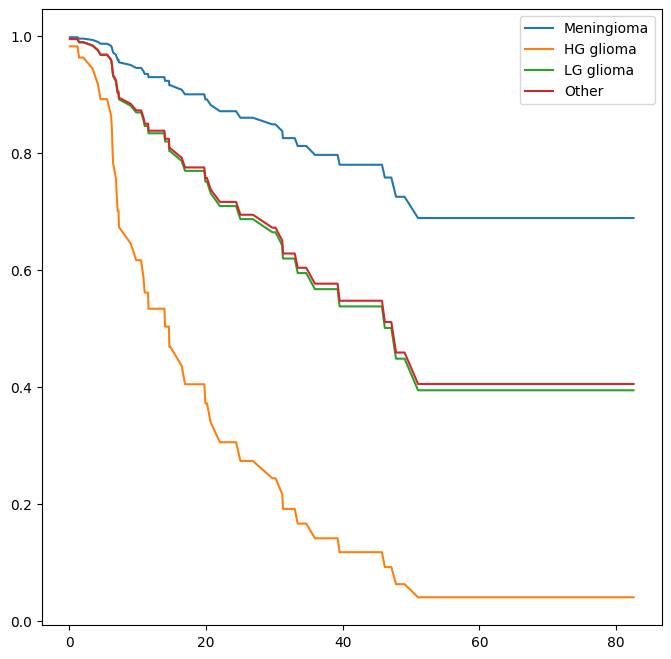

In [17]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);


## Publication Data
The  `Publication`  data   presented in Section 11.5.4  can be
found in the `ISLP` package.
We first reproduce Figure 11.5  by plotting the Kaplan-Meier curves
stratified on the  `posres`  variable, which records whether the
study had a positive or negative result.

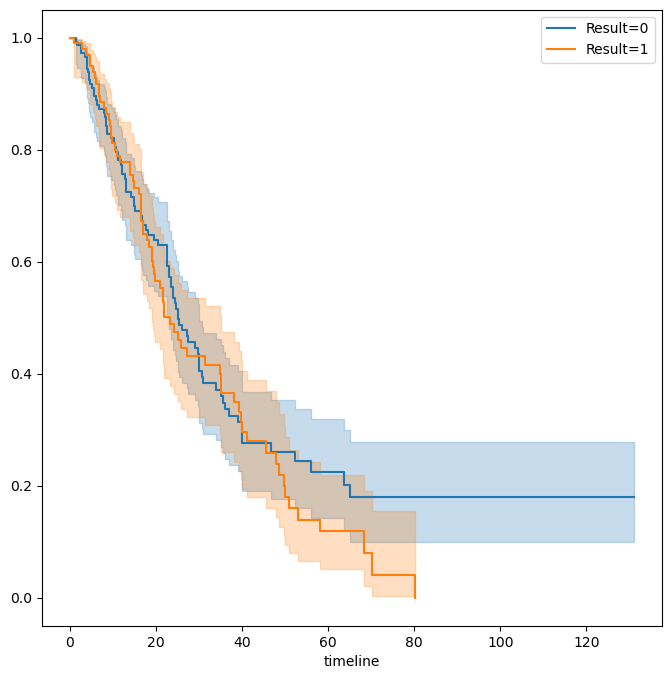

In [20]:
fig, ax = subplots(figsize=(8,8))
Publication = load_data('Publication')
by_result = {}
for result, df in Publication.groupby('posres'):
    by_result[result] = df
    km_result = km.fit(df['time'], df['status'])
    km_result.plot(label='Result=%d' % result, ax=ax)


As discussed previously, the $p$-values from fitting Cox’s
proportional hazards model to the `posres` variable are quite
large, providing no evidence of a difference in time-to-publication
between studies with positive versus negative results.

In [21]:
posres_df = MS(['posres',
                'time',
                'status'],
                intercept=False).fit_transform(Publication)
posres_fit = coxph().fit(posres_df,
                         'time',
                         'status')
posres_fit.summary[['coef', 'se(coef)', 'p']]


,coef,se(coef),p
covariate,,,
posres,0.148076,0.161625,0.359579


However, the results change dramatically when we include other
predictors in the model. Here we exclude the funding mechanism
variable.

In [22]:
model = MS(Publication.columns.drop('mech'),
           intercept=False)
coxph().fit(model.fit_transform(Publication),
            'time',
            'status').summary[['coef', 'se(coef)', 'p']]


,coef,se(coef),p
covariate,,,
posres,0.570773,0.175960,1.179610e-03
multi,-0.040860,0.251194,8.707842e-01
clinend,0.546183,0.262000,3.709944e-02
sampsize,0.000005,0.000015,7.507005e-01
budget,0.004386,0.002465,7.515984e-02
impact,0.058318,0.006676,2.426306e-18


We see that there are a number of statistically significant variables,
including whether the trial focused on a clinical endpoint, the impact
of the study, and whether the study had positive or negative results.

## Call Center Data

In this section, we will simulate survival data using the relationship
between cumulative hazard and
the survival function explored in Exercise 8.
Our simulated data will represent the observed
wait times (in seconds) for 2,000 customers who have phoned a call
center.  In this context, censoring occurs if a customer hangs up
before his or her call is answered.

There are three covariates: `Operators` (the number of call
center operators available at the time of the call, which can range
from $5$ to $15$), `Center` (either A, B, or C), and
`Time` of day (Morning, Afternoon, or Evening). We generate data
for these covariates so that all possibilities are equally likely: for
instance, morning, afternoon and evening calls are equally likely, and
any number of operators from $5$ to $15$ is equally likely. 

In [23]:
rng = np.random.default_rng(10)
N = 2000
Operators = rng.choice(np.arange(5, 16),
                       N,
                       replace=True)
Center = rng.choice(['A', 'B', 'C'],
                    N,
                    replace=True)
Time = rng.choice(['Morn.', 'After.', 'Even.'],
                   N,
                   replace=True)
D = pd.DataFrame({'Operators': Operators,
                  'Center': pd.Categorical(Center),
                  'Time': pd.Categorical(Time)})

We then build a model matrix (omitting the intercept)

In [24]:
model = MS(['Operators',
            'Center',
            'Time'],
           intercept=False)
X = model.fit_transform(D)

It is worthwhile to take a peek at the model matrix `X`, so
that we can be sure that we understand how the variables have been coded. By default,
the levels of categorical variables are sorted and, as usual, the first column of the one-hot encoding
of the variable is dropped.

In [25]:
X[:5]


,Operators,Center[B],Center[C],Time[Even.],Time[Morn.]
0,13,0.0,1.0,0.0,0.0
1,15,0.0,0.0,1.0,0.0
2,7,1.0,0.0,0.0,1.0
3,7,0.0,1.0,0.0,1.0
4,13,0.0,1.0,1.0,0.0


Next,  we specify the coefficients and the hazard function.

In [26]:
true_beta = np.array([0.04, -0.3, 0, 0.2, -0.2])
true_linpred = X.dot(true_beta)
hazard = lambda t: 1e-5 * t


Here, we have set the coefficient associated with `Operators` to
equal $0.04$; in other words, each additional operator leads to a
$e^{0.04}=1.041$-fold increase in the “risk” that the call will be
answered, given the `Center` and `Time` covariates. This
makes sense: the greater the number of operators at hand, the shorter
the wait time! The coefficient associated with `Center == B` is
$-0.3$, and `Center == A` is treated as the baseline. This means
that the risk of a call being answered at Center B is 0.74 times the
risk that it will be answered at Center A; in other words, the wait
times are a bit longer at Center B.

Recall from Section 2.3.7 the use of `lambda`
for creating short functions on the fly.
We use the function
`sim_time()` from the `ISLP.survival` package. This function
uses the relationship between the survival function
and cumulative hazard $S(t) = \exp(-H(t))$ and the specific
form of the cumulative hazard function in the Cox model
to simulate data based on values of the linear predictor
`true_linpred` and the cumulative hazard. 
 We need to provide the cumulative hazard function, which we do here.

In [27]:
cum_hazard = lambda t: 1e-5 * t**2 / 2


We are now ready to generate data under the Cox proportional hazards
model. We truncate the maximum time to 1000 seconds to keep
simulated wait times reasonable. The function
`sim_time()` takes a linear predictor,
a cumulative hazard function and a
random number generator.

In [28]:
W = np.array([sim_time(l, cum_hazard, rng)
              for l in true_linpred])
D['Wait time'] = np.clip(W, 0, 1000)


We now simulate our censoring variable, for which we assume
90% of calls were answered (`Failed==1`) before the
customer hung up (`Failed==0`).

In [29]:
D['Failed'] = rng.choice([1, 0],
                         N,
                         p=[0.9, 0.1])
D[:5]


,Operators,Center,Time,Wait time,Failed
0,13,C,After.,525.064979,1
1,15,A,Even.,254.677835,1
2,7,B,Morn.,487.739224,1
3,7,C,Morn.,308.580292,1
4,13,C,Even.,154.174608,1


In [30]:
D['Failed'].mean()


0.9075

We now plot  Kaplan-Meier survival curves. First, we stratify by `Center`.

Text(0.5, 1.0, 'Probability of Still Being on Hold')

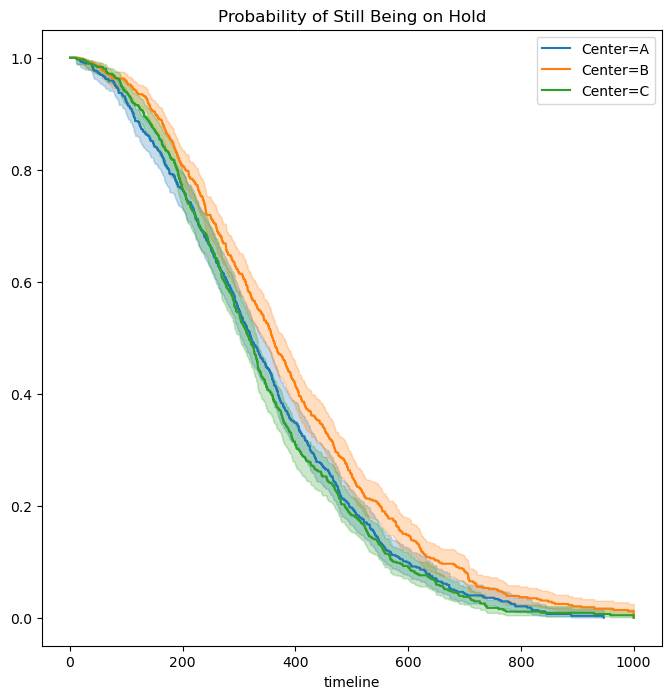

In [31]:
fig, ax = subplots(figsize=(8,8))
by_center = {}
for center, df in D.groupby('Center'):
    by_center[center] = df
    km_center = km.fit(df['Wait time'], df['Failed'])
    km_center.plot(label='Center=%s' % center, ax=ax)
ax.set_title("Probability of Still Being on Hold")


Next, we stratify by `Time`.

Text(0.5, 1.0, 'Probability of Still Being on Hold')

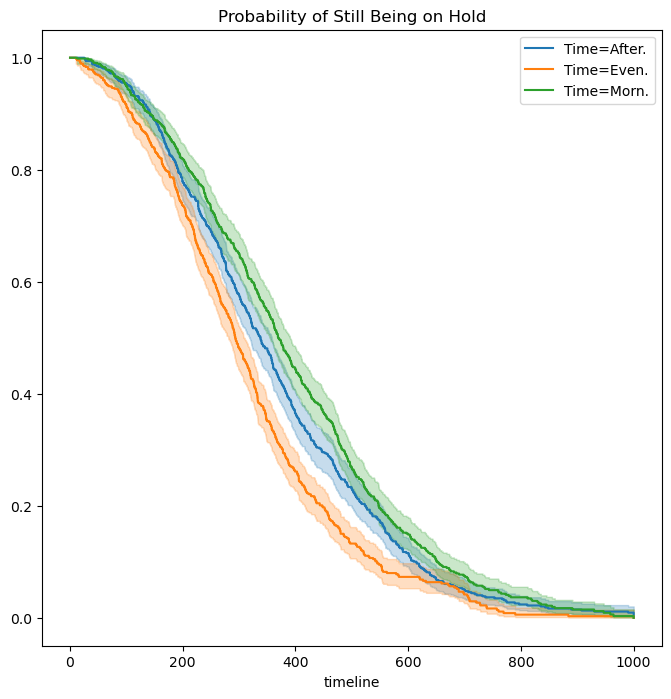

In [32]:
fig, ax = subplots(figsize=(8,8))
by_time = {}
for time, df in D.groupby('Time'):
    by_time[time] = df
    km_time = km.fit(df['Wait time'], df['Failed'])
    km_time.plot(label='Time=%s' % time, ax=ax)
ax.set_title("Probability of Still Being on Hold")


It seems that calls at Call Center B take longer to be answered than
calls at Centers A and C. Similarly, it appears that wait times are
longest in the morning and shortest in the evening hours. We can use a
log-rank test to determine whether these differences are statistically
significant using the function `multivariate_logrank_test()`.

In [33]:
multivariate_logrank_test(D['Wait time'],
                          D['Center'],
                          D['Failed'])


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          20.30 <0.005     14.65

Next, we consider the  effect of `Time`.

In [34]:
multivariate_logrank_test(D['Wait time'],
                          D['Time'],
                          D['Failed'])


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          49.90 <0.005     35.99

As in the case of a categorical variable with 2 levels, these
results are similar to the likelihood ratio test
from the Cox proportional hazards model. First, we
look at the results for  `Center`.

In [35]:
X = MS(['Wait time',
        'Failed',
        'Center'],
        intercept=False).fit_transform(D)
F = coxph().fit(X, 'Wait time', 'Failed')
F.log_likelihood_ratio_test()


<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          20.58 <0.005     14.85

Next, we look at the results for `Time`.

In [36]:
X = MS(['Wait time',
        'Failed',
        'Time'],
       intercept=False).fit_transform(D)
F = coxph().fit(X, 'Wait time', 'Failed')
F.log_likelihood_ratio_test()


<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          48.12 <0.005     34.71

We find that differences between centers are highly significant, as
are differences between times of day.

Finally, we fit Cox's proportional hazards model to the data.

In [37]:
X = MS(D.columns,
       intercept=False).fit_transform(D)
fit_queuing = coxph().fit(
                  X,
                 'Wait time',
                 'Failed')
fit_queuing.summary[['coef', 'se(coef)', 'p']]


,coef,se(coef),p
covariate,,,
Operators,0.043934,0.007520,5.143589e-09
Center[B],-0.236060,0.058113,4.864162e-05
Center[C],0.012231,0.057518,8.316096e-01
Time[Even.],0.268845,0.057797,3.294956e-06
Time[Morn.],-0.148217,0.057334,9.733557e-03


The $p$-values for Center B and evening time
are very small. It is also clear that the
hazard --- that is, the instantaneous risk that a call will be
answered --- increases with the number of operators. Since we
generated the data ourselves, we know that the true coefficients for
 `Operators`, `Center = B`, `Center = C`, 
`Time = Even.` and `Time = Morn.`   are $0.04$, $-0.3$,
$0$,   $0.2$, and $-0.2$, respectively. The coefficient estimates
from the fitted Cox model are fairly accurate.

